In [1]:
import numpy as np
import pyproj
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams["font.size"] = 20

import torch
from OkadaTorch import OkadaWrapper
okada = OkadaWrapper()

In [2]:
# domain
lon_min, lon_max = 142, 148
lat_min, lat_max = 37, 43
dlon, dlat = 0.05, 0.05
nlon, nlat = int((lon_max-lon_min)/dlon)+1, int((lat_max-lat_min)/dlon)+1
lon_mid, lat_mid = (lon_min+lon_max)/2, (lat_min+lat_max)/2


# coordinate transformation
ll2xy = pyproj.Transformer.from_crs(
    crs_from="EPSG:4326", # WGS84
    crs_to=f"+proj=tmerc +lon_0={lon_mid} +lat_0={lat_mid} +ellps=WGS84 +datum=WGS84 +units=km", 
    always_xy=True
)

lon = np.linspace(lon_min, lon_max, nlon)
lat = np.linspace(lat_min, lat_max, nlat)
Lon, Lat = np.meshgrid(lon, lat)
x, y = ll2xy.transform(Lon, Lat)
X = torch.from_numpy(x)
Y = torch.from_numpy(y)

z = np.zeros_like(x)
Z = torch.from_numpy(z)


# source parameters
lat_fault = 40.2224
lon_fault = 144.8678
x_fault, y_fault = ll2xy.transform(lon_fault, lat_fault)


# specify `requires_grad=True`
x_fault = torch.tensor(x_fault, requires_grad=True) # km
y_fault = torch.tensor(y_fault, requires_grad=True) # km
depth = torch.tensor(0.1, requires_grad=True) # km
length = torch.tensor(218.0, requires_grad=True) # km
width = torch.tensor(46.0, requires_grad=True) # km
strike = torch.tensor(189.0, requires_grad=True)
dip = torch.tensor(60.0, requires_grad=True)
rake = torch.tensor(270.0, requires_grad=True)
slip = torch.tensor(5.62, requires_grad=True)

In [3]:
coords = {
    "x": X,
    "y": Y,
    "z": Z
}
params = {
    "x_fault": x_fault,
    "y_fault": y_fault,
    "depth": depth,
    "length": length,
    "width": width,
    "strike": strike,
    "dip": dip,
    "rake": rake,
    "slip": slip
}

# Gradient of `ux`, `uy` and `uz` with respect to `x`, `y` and `z`

Note: In the following, `uij` means $\dfrac{\partial u_i}{\partial x_j}$

In [4]:
# Analytical solution
ux, uy, uz, uxx, uyx, uzx, uxy, uyy, uzy, uxz, uyz, uzz = okada.compute(
    coords, params, compute_strain=True, is_degree=True, fault_origin="topleft"
)

# by using AD
UXX, UYX, UZX = okada.gradient(coords, params, arg="x", compute_strain=False, is_degree=True, fault_origin="topleft")
UXY, UYY, UZY = okada.gradient(coords, params, arg="y", compute_strain=False, is_degree=True, fault_origin="topleft")
UXZ, UYZ, UZZ = okada.gradient(coords, params, arg="z", compute_strain=False, is_degree=True, fault_origin="topleft")

In [5]:
# errors are very small
print(torch.abs(UXX-uxx).max())
print(torch.abs(UYX-uyx).max())
print(torch.abs(UZX-uzx).max())
print(torch.abs(UXY-uxy).max())
print(torch.abs(UYY-uyy).max())
print(torch.abs(UZY-uzy).max())
print(torch.abs(UXZ-uxz).max())
print(torch.abs(UYZ-uyz).max())
print(torch.abs(UZZ-uzz).max())

tensor(5.8977e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.2821e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.0343e-07, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(9.3454e-09, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.5506e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.6387e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.7230e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(1.7533e-08, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(6.6369e-09, dtype=torch.float64, grad_fn=<MaxBackward1>)


# Gradient of `uz` with respect to parameters

In [6]:
# import os
# os.makedirs("figs_grad", exist_ok=True)

In [7]:
ss = torch.sin(torch.deg2rad(strike))
cs = torch.cos(torch.deg2rad(strike))
sd = torch.sin(torch.deg2rad(dip))
cd = torch.cos(torch.deg2rad(dip))

x_corners = [
    x_fault,
    x_fault               + width * cd * cs,
    x_fault + length * ss + width * cd * cs,
    x_fault + length * ss
]
y_corners = [
    y_fault,
    y_fault               - width * cd * ss,
    y_fault + length * cs - width * cd * ss,
    y_fault + length * cs
]

lon_corners, lat_corners = ll2xy.transform(x_corners, y_corners, direction = "INVERSE")
corners = np.column_stack((np.array(lon_corners), np.array(lat_corners)))

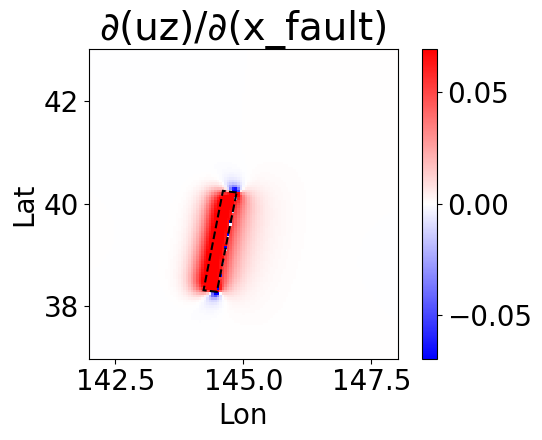

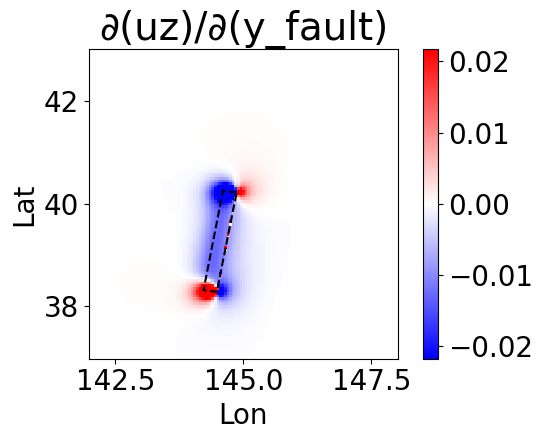

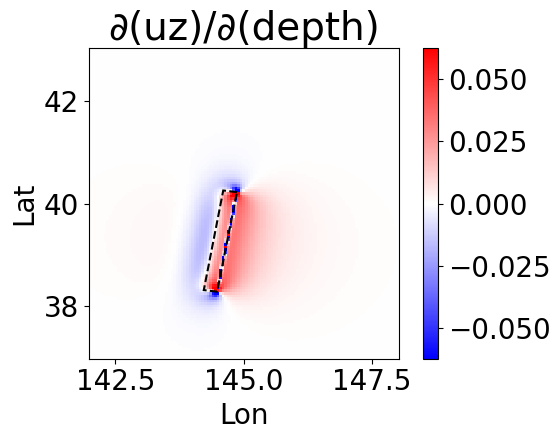

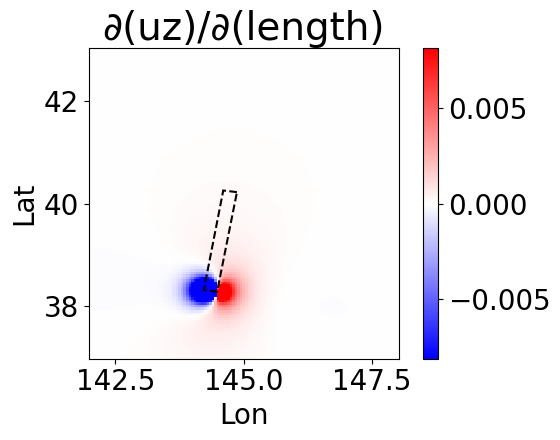

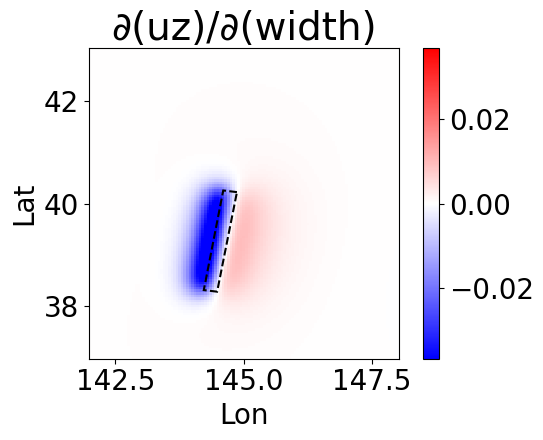

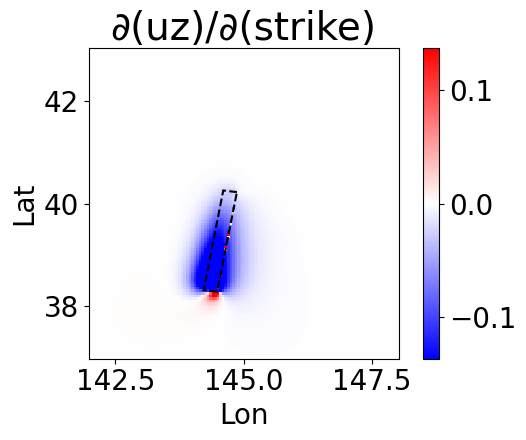

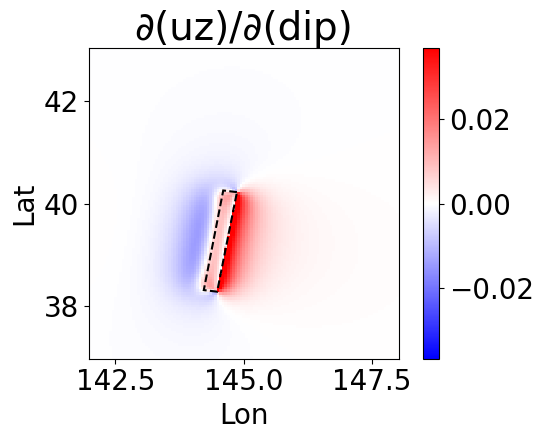

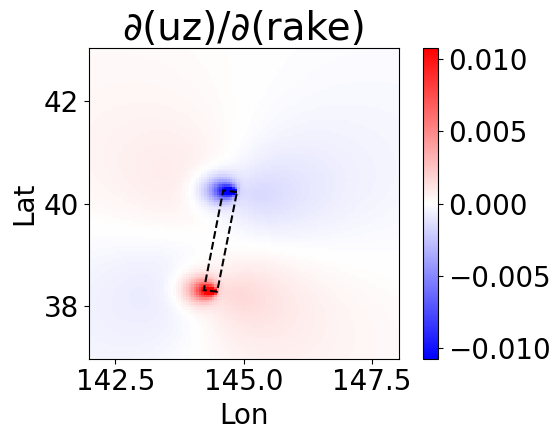

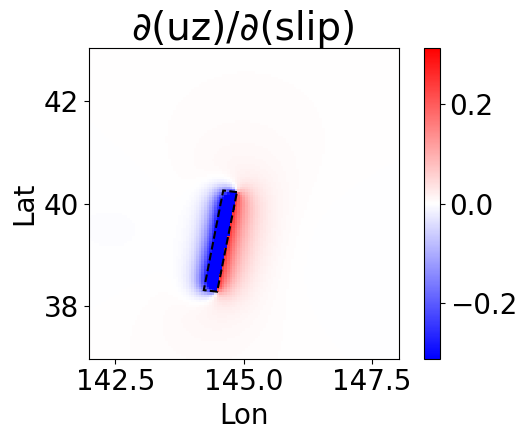

In [ ]:
for i, var in enumerate(list(params)):

    _, _, duz = okada.gradient(coords, params, arg=var, compute_strain=False, is_degree=True, fault_origin="topleft")

    amp = np.abs(duz.detach().numpy()).mean() * 20

    fig, ax = plt.subplots()
    im = ax.pcolormesh(Lon, Lat, duz.detach().numpy(), cmap="bwr", vmin=-amp, vmax=amp)
    rect = patches.Polygon(corners, ls="--", lw=1.5, closed=True, edgecolor='black', fill=False)
    ax.add_patch(rect)
    ax.set_aspect("equal")
    ax.set_xlabel("Lon")
    ax.set_ylabel("Lat")
    ax.set_title(f"∂(uz)/∂({var})", fontsize=28)
    fig.colorbar(im)
    fig.show()

    # plt.tight_layout()
    # fig.savefig(f"figs_grad/∂uz∂{var}.png")